In [65]:
# first we import all relevant packages
from bulk import * # bulk.py stores a lot of my personal functions, i.e. for reading from the .data files and such
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pynbody
from scipy import stats
from scipy.stats import binned_statistic


In [66]:
# we set the global matplotlib parameters so the fonts are all consistent and serif 
mpl.rc('font',**{'family':'serif','monospace':['Palatino']})
mpl.rc('text', usetex=True)
mpl.rcParams.update({'font.size': 9})

In [67]:
# wilson score interval is used to calculate error in fractional quantities
def WilsonScoreInterval(z,p,M):
    return (1/(1+(z**2)/M)) * (p + ((z**2)/(2*M)) + z * np.sqrt((p*(1-p)/M) + (z**2)/(4*M**2)))

# quenched definition
def quenched(data):
    return np.array(data.sSFR < 1e-11, dtype=bool)

def quenched_McConnachie(data):
    return np.array(np.array(data.mHI,dtype=float)/np.array(data.M_star) < 0.2, dtype=bool)

def quenched_Weisz(data):
    sfh = data.sfh
    bincenters = 0.5*(data.sfhbins[1:]+data.sfhbins[:-1])
    sfhmstar = np.sm(sfh)
    
    c_sfh = np.empty(shape=sfh.shape)
    for i in range(len(bincenters)):
        c_sfh[i] = np.sum(sfh[:i+1])/sfhmstar
    

In [68]:
# load in the McConnachie2012Data.csv file which I downloaded from SIMBAD
mcconnachie = pd.read_csv('McConnachie2012Data.csv')
MW = mcconnachie[(mcconnachie.SubG=='MW')&(mcconnachie.DMW < 300)] # select MW satellites

# define quenched the way that Wetzel (2015) did: mHI/Mstar < 0.1, or mHI is nan, since that means HI is undetected
q = np.array((MW.mHI / MW.Mstar < 0.2) | np.isnan(MW.mHI),dtype=bool)
bins = np.arange(3,11,1) # 1 dex bins
mstar = np.log10(MW.Mstar*1e6) 
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
MW_Mc = y2/y1 
bc_Mc = bincenters # bincenters will be the same for all three
MW_N_Mc = y1

M31 = mcconnachie[(mcconnachie.SubG=='M31')&(mcconnachie.DM31 < 300)] # select M31 satellites
M31 = M31[M31.Name != "Triangulum"] # remove Triangulum since it doesn't have enough info
q = np.array((M31.mHI / M31.Mstar < 0.2) | np.isnan(M31.mHI),dtype=bool) # define quenched
mstar = np.log10(M31.Mstar*1e6)
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
M31_Mc = y2/y1
M31_N_Mc = y1


# now we want the data for both, combined
All = MW.append(M31) 

q = np.array((All.mHI / All.Mstar < 0.2) | np.isnan(All.mHI),dtype=bool)
mstar = np.log10(All.Mstar*1e6)
y1, binEdges = np.histogram(mstar, bins=bins)
y2, binEdges = np.histogram(mstar[q], bins=bins)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
All_Mc = y2/y1
All_N_Mc = y1

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide


# Figure 3 (quenched fraction vs. mass)

/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:114: RuntimeWarning: invalid value encountered in true_divide
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/akinshol/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


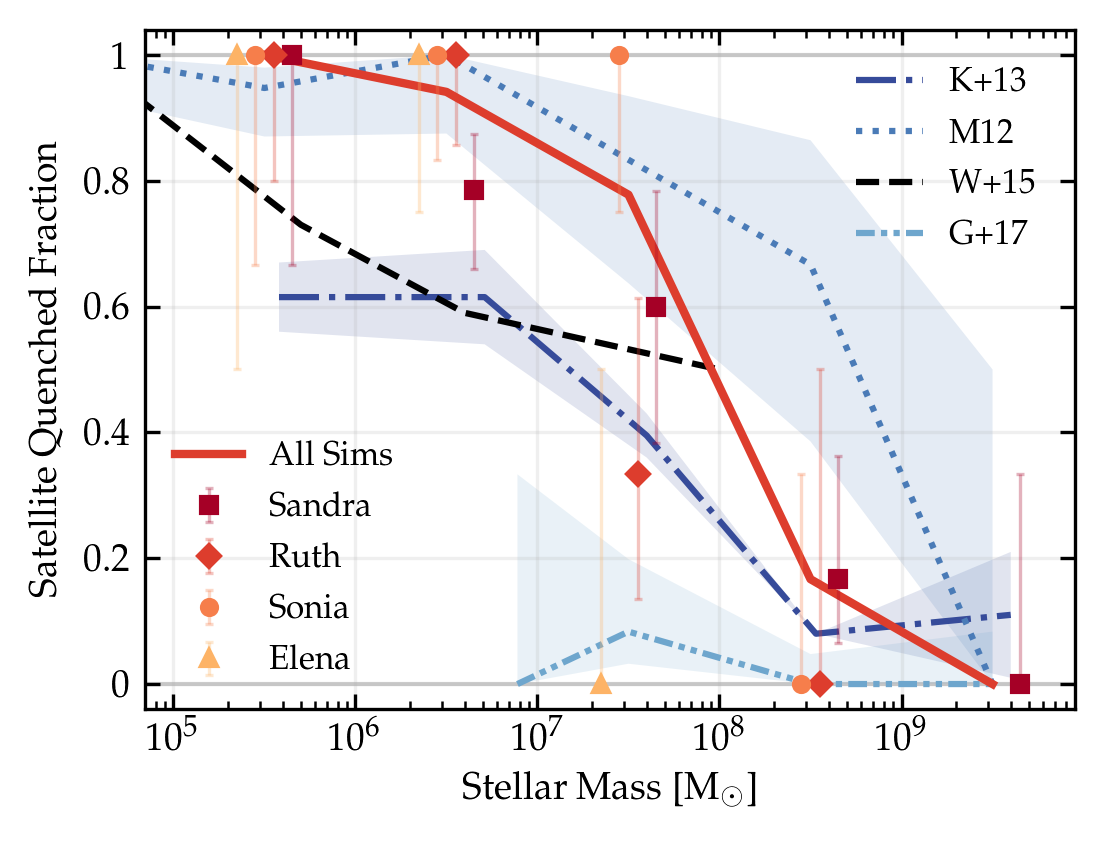

In [85]:
# load in the data and clean up 
data = read_sat()
data = data[data['n_star']>100]

# load in distance to nearest host
dist, vir = distance_to_nearest_host(data)
s = dist < 300 # define satellites as those where dist < 500 kpc (to go on lower panel)
s = s[dist!=0]
# Mr = np.array(data.R_mag, dtype=float)[dist!=0]
# Mr_sol = 4.65
# L = 10**((Mr_sol - Mr)/2.5)
# mass = np.log10(L)
mass = np.log10(np.array(data.M_star, dtype=float))[dist!=0]
q = quenched(data)[dist!=0]
q_McConnachie = quenched_McConnachie(data)[dist!=0]
dist = dist[dist!=0]


# set up import plotting stuff
nbins = 5
colors = ['#A50026','#DD3D2D', '#F67E4B', '#FDB366']
obs_colors = ['#364B9A', '#4A7BB7', '#6EA6CD', '#98CAE1'] 
offsets = np.array([-0.15,-0.05,0.05,0.15])


fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=300,sharex=True)


# First, plot all sims
bin_edges = np.arange(3,11)
y2, binEdges2 = np.histogram(mass[s],bins=bin_edges)
y1, binEdges1 = np.histogram(mass[q & s], bins=bin_edges)
bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])
p, = ax.plot(10**bincenters, y1/y2, '-', color='#DD3D2D', linewidth=2, zorder=20)
sim_plots = [p]
sim_labels = ['All Sims']



# add Karachentsev et al (2013) observational data compiled by Weisz (2015) (data from table)
bincenters = np.array([5.58,6.71,7.6,8.53,9.6])
y1 = np.array([0.56,0.54,0.36,0.08,0.21])
y2 = np.array([0.67,0.69,0.43,0.08,0.01])
ax.fill_between(10**bincenters, y1, y2, fc=obs_colors[0], ec='none', alpha=0.15, lw=0.5)
p, = ax.plot(10**bincenters, (y1+y2)/2, '-.', color=obs_colors[0], markersize=2.5, linewidth=1.5)
obs_plots = [p]
obs_labels = ['K+13']

# add McConnachie (2012) data as seen in Wetzel (2015) observational data (data from previous cell)
yerr_lower = All_Mc - WilsonScoreInterval(-1,All_Mc,All_N_Mc)
yerr_upper = WilsonScoreInterval(1,All_Mc,All_N_Mc)-All_Mc
p, = ax.plot(10**bc_Mc[1:], All_Mc[1:], ':', color=obs_colors[1], markersize=2.5, linewidth=1.5)
obs_plots.append(p)
obs_labels.append('M12')
ax.fill_between(10**bc_Mc[1:], All_Mc[1:] - yerr_lower[1:], All_Mc[1:] + yerr_upper[1:], 
               fc = obs_colors[1], ec='none', alpha=0.15, lw=0.5)


# add Weisz et al (2015) observational data (data from table)
bincenters = np.array([4.5,5.7,6.6,8.0])
y = np.array([1,0.73,0.59,0.5])
p, = ax.plot(10**bincenters, y, '--', color='k', markersize=2.5, linewidth=1.5)

obs_plots.append(p)
obs_labels.append('W+15')


# add Geha et al. (2017) data (SAGA)
SAGA = pd.read_csv('SAGA_data_cleaned.csv')
SAGA = SAGA[SAGA['M_r'] < -12.3]

Mr_sol = 4.65
L = 10**((Mr_sol - np.array(SAGA.M_r))/2.5)
mass = np.log10(L)

bin_edges = [6.78, 7, 8, 9, 10]
y1, binEdges = np.histogram(mass, bin_edges)
bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
y2, binEdges = np.histogram(mass[SAGA.halpha=='N'], bins = binEdges)
y = y2/y1
p, = ax.plot(10**bincenters,y, linestyle=(0, (3, 1, 1, 1, 1, 1)), color=obs_colors[-2], linewidth=1.5)
SAGA_lower = WilsonScoreInterval(-1,y,y1)
SAGA_upper = WilsonScoreInterval(1,y,y1) 
ax.fill_between(10**bincenters, SAGA_lower, SAGA_upper, fc=obs_colors[-2], ec='none', alpha=0.15, lw=0.5)

obs_plots.append(p)
obs_labels.append('G+17')


for name,label,color,mark,off in zip(['h148','h229','h242','h329'],['Sandra','Ruth','Sonia','Elena'],colors,['s','D','o','^'],offsets):
    data = read_file(name)
    data = data[data['n_star']>100]

    # load in distance to nearest host
    dist, vir = distance_to_nearest_host(data)
    s = dist < 300 # define satellites as those where dist < 500 kpc \
    s = s[dist!=0]
    
    # Mr = np.array(data.R_mag, dtype=float)[dist!=0]
    # Mr_sol = 4.65
    # L = 10**((Mr_sol - Mr)/2.5)
    # mass = np.log10(L)
    mass = np.log10(np.array(data.M_star, dtype=float))[dist!=0]

    q = quenched(data)[dist!=0]
    dist = dist[dist!=0]

    bin_edges = np.arange(3,11)
    y2, binEdges2 = np.histogram(mass,bins=bin_edges)
    bincenters2 = 0.5*(binEdges2[1:]+binEdges2[:-1])
    y1, binEdges1 = np.histogram(mass[q],bins=bin_edges)
    bincenters = 0.5*(binEdges1[1:]+binEdges1[:-1])

    p = y1/y2
    M = y2

    markers, caps, bars = ax.errorbar(10**(bincenters-off),WilsonScoreInterval(0,p,M), 
                                      yerr=np.array([p - WilsonScoreInterval(-1,p,M), WilsonScoreInterval(1,p,M) - p]),
                                      color=color,
                                      marker=mark,
                                      ms=np.sqrt(13), 
                                      linestyle='none', 
                                      linewidth=2,
                                      ecolor=color,
                                      elinewidth=0.8, 
                                      capsize=1,
                                      capthick=0.8,
                                      clip_on=False,
                                      alpha = 1,
                                      zorder=105)
    
    # loop through bars and caps and set the alpha value
    [bar.set_alpha(0.3) for bar in bars]
    [cap.set_alpha(0.3) for cap in caps]
    
    sim_plots.append(mpl.container.ErrorbarContainer((markers, caps, bars), has_yerr=True))
    sim_labels.append(label)



ax.plot([1e3,1e12],[0,0],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
ax.plot([1e3,1e12],[1,1],linestyle='-',color='k',linewidth=1,zorder=0,alpha=0.2)
    
# labels and limits
ax.set_xlabel('Stellar Mass [$\mathrm{M}_{\odot}$]')
ax.set_ylabel('Satellite Quenched Fraction')
ax.set_ylim(-0.04,1.04)
ax.set_xlim(7e4,9e9)
ax.grid(alpha=0.2)

# legend and ticks
leg1 = ax.legend(sim_plots, sim_labels, prop={'size':8},frameon=False, loc='lower left')
leg2 = ax.legend(obs_plots, obs_labels, prop={'size':8},frameon=False, loc=(0.75,0.65))
ax.add_artist(leg1)

ax.semilogx()
ax.tick_params(direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.set_yticklabels([None,0,0.2,0.4,0.6,0.8,1])

# save and show
plt.savefig('plots/QF_F19.png',dpi=300)
plt.show()


In [75]:
SAGA

,name,sdss_objid,ra,dec,r_o,M_r,g-r_o,mu_r,r_proj,halpha,v-v_host,tel,complete
0,NGC 5962,1.23767E+18,234.132926,16.440455,14.3,-18.0,0.51,22.1,81,Y,-71.9,SDSS,Y
1,NGC 5962,1.23767E+18,233.787037,16.870438,15.4,-16.8,0.38,22.5,206,Y,32.5,SDSS,Y
2,NGC 6181,1.23766E+18,247.840030,20.184076,13.3,-19.4,0.59,21.8,255,Y,189.3,SDSS,Y
3,NGC 6181,1.23766E+18,248.393226,19.946140,15.6,-17.0,0.40,20.1,186,Y,62.3,SDSS,Y
4,NGC 6181,1.23766E+18,248.051340,19.695740,16.6,-16.0,0.38,22.4,80,Y,125.3,AAT,Y
5,NGC 6181,1.23766E+18,247.825892,20.210879,16.9,-15.8,0.34,23.1,273,Y,89.3,AAT,Y
6,NGC 6181,1.23766E+18,247.877388,20.093625,17.0,-15.7,0.25,24.0,198,Y,109.7,SDSS,Y
7,NGC 6181,1.23766E+18,248.152080,19.810259,17.6,-15.1,0.29,23.4,37,Y,-88.2,MMT,Y
8,NGC 6181,1.23766E+18,248.580638,19.720801,18.2,-14.5,0.86,24.3,285,Y,77.3,AAT,Y
9,NGC 6181,1.23766E+18,248.195369,19.867013,18.6,-14.1,0.23,23.2,65,Y,95.3,MMT,Y


In [78]:
Mr_sol = 4.65
L = 10**((Mr_sol - (-12.3))/2.5)
L

6025595.860743593

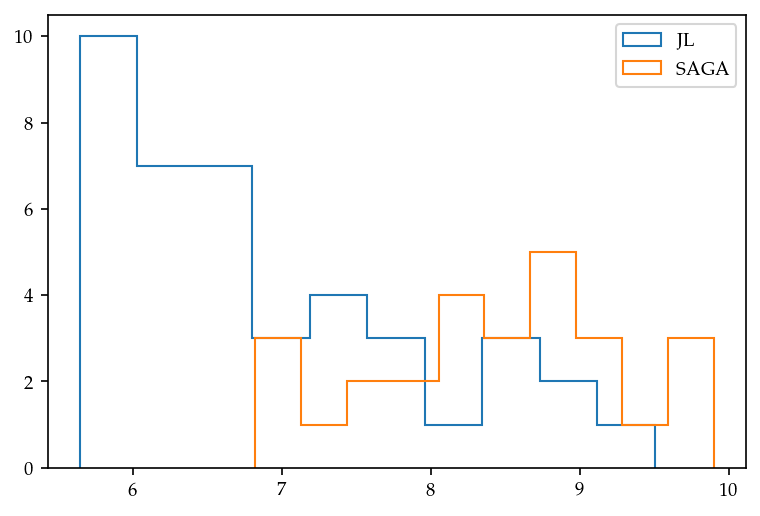

26 out of 27


In [40]:
# load in the data and clean up 
data = read_sat()
data = data[data['n_star']>100]

# load in distance to nearest host
dist, vir = distance_to_nearest_host(data)
data = data[(dist < 300) & (dist != 0)]
Mr = np.array(data.R_mag, dtype=float)
Mr_sol = 4.6
L = 10**((Mr_sol - Mr)/2.5)
mass_JL = np.log10(L)



# add Geha et al. (2017) data (SAGA)
SAGA = pd.read_csv('SAGA_data_cleaned.csv')
SAGA = SAGA[(SAGA.complete=='Y')&(SAGA.M_r < -12.3)]

Mr_sol = 4.65
L = 10**((Mr_sol - np.array(SAGA.M_r))/2.5)
mass_SAGA = np.log10(L)


plt.figure(dpi=150)
plt.hist(mass_JL,label='JL', histtype='step')
plt.hist(mass_SAGA[SAGA.complete=='Y'],label='SAGA',histtype='step')
plt.legend()
plt.show()

quenched = len(SAGA[(SAGA.complete=='Y')&(SAGA.M_r < -12.3)&(SAGA.halpha=='Y')])
total = len(SAGA[(SAGA.complete=='Y')&(SAGA.M_r < -12.3)])
print(f"{quenched} out of {total}")


In [51]:
print('%.2f percent of SAGA satellites have M_* < 1e8' % (len(mass_SAGA[mass_SAGA < 8])/len(mass_SAGA)*100))
print('%.2f percent of SAGA satellites below M_* = 1e8 are quenched' % (len(mass_SAGA[(mass_SAGA < 8)&(SAGA.halpha=='N')])/len(mass_SAGA[mass_SAGA < 8])*100))

29.63 percent of SAGA satellites have M_* < 1e8
12.50 percent of SAGA satellites below M_* = 1e8 are quenched


In [52]:
faint_data = data[mass_JL < 8]
print('%.2f percent of JL satellites have M_* < 1e8' % (len(faint_data)/len(data)*100))

comparison_data = data[(mass_JL < 8) & (mass_JL > np.min(mass_SAGA))]
print('%.2f percent of JL satellites below M_* = 1e8 (but above SAGA completeness limit) are quenched' % (len(comparison_data[comparison_data.sSFR < 1e-11])/len(comparison_data)*100))

# len(mass_JL[data.sSFR < 1e-11])/len(mass_JL)

82.93 percent of JL satellites have M_* < 1e8
80.00 percent of JL satellites below M_* = 1e8 (but above SAGA completeness limit) are quenched


In [46]:
data[mass_JL > 8].sSFR < 1e-11

1     False
2     False
3     False
7     False
12    False
1     False
2     False
Name: sSFR, dtype: bool

In [56]:
print('SAGA completeness limit is roughly %.2e' % 10**np.min(mass_SAGA))

SAGA completeness limit is roughly 6.61e+06


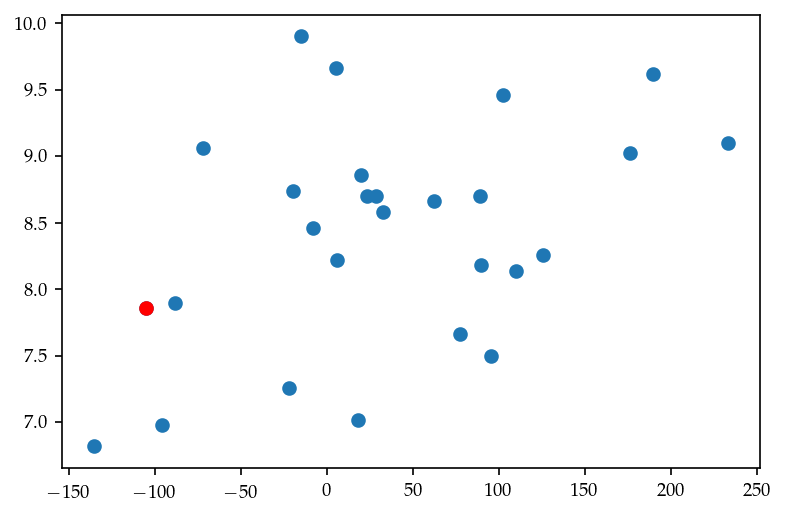

In [63]:
plt.figure(dpi=150)
plt.scatter(SAGA['v-v_host'], mass_SAGA)
plt.scatter(SAGA['v-v_host'][SAGA.halpha=='N'], mass_SAGA[SAGA.halpha=='N'],c='r')
plt.show()

In [62]:
SAGA

,name,sdss_objid,ra,dec,r_o,M_r,g-r_o,mu_r,r_proj,halpha,v-v_host,tel,complete
0,NGC 5962,1.23767E+18,234.132926,16.440455,14.3,-18.0,0.51,22.1,81,Y,-71.9,SDSS,Y
1,NGC 5962,1.23767E+18,233.787037,16.870438,15.4,-16.8,0.38,22.5,206,Y,32.5,SDSS,Y
2,NGC 6181,1.23766E+18,247.840030,20.184076,13.3,-19.4,0.59,21.8,255,Y,189.3,SDSS,Y
3,NGC 6181,1.23766E+18,248.393226,19.946140,15.6,-17.0,0.40,20.1,186,Y,62.3,SDSS,Y
4,NGC 6181,1.23766E+18,248.051340,19.695740,16.6,-16.0,0.38,22.4,80,Y,125.3,AAT,Y
5,NGC 6181,1.23766E+18,247.825892,20.210879,16.9,-15.8,0.34,23.1,273,Y,89.3,AAT,Y
6,NGC 6181,1.23766E+18,247.877388,20.093625,17.0,-15.7,0.25,24.0,198,Y,109.7,SDSS,Y
7,NGC 6181,1.23766E+18,248.152080,19.810259,17.6,-15.1,0.29,23.4,37,Y,-88.2,MMT,Y
8,NGC 6181,1.23766E+18,248.580638,19.720801,18.2,-14.5,0.86,24.3,285,Y,77.3,AAT,Y
9,NGC 6181,1.23766E+18,248.195369,19.867013,18.6,-14.1,0.23,23.2,65,Y,95.3,MMT,Y


In [89]:
len(SAGA[SAGA.M_r > -15.2])/len(SAGA)

0.28888888888888886

In [91]:
len(SAGA[(SAGA.M_r < -12.3)&(SAGA.M_r > -15.2)&(SAGA.complete=='Y')])/len(SAGA[(SAGA.M_r < -12.3)&(SAGA.complete=='Y')])

0.2962962962962963

In [93]:
len(SAGA[(SAGA.M_r < -12.3)&(SAGA.halpha == 'N')&(SAGA.complete=='Y')])

1